In [19]:
# Imports
import numpy as np
import pandas as pd
import pickle
import random
import re
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, roc_auc_score
import pypdfium2 as pdfium

# set randomn seed for reproducibility
seed = 23
random.seed(seed)
np.random.seed(seed)

# Define embeddings - remember to change the embeddings file to 1000, 2000 or 4000
# Select context, context_medium or context_long depending on 1000, 2000 or 4000
embedding_length = [1000, 2000, 4000][2]
book = [2450, 'ww2'][0]
ctx_length_to_name = {1000: 'context', 2000: 'context_medium', 4000: 'context_long'}

In [20]:
# Select book at make sentences again
if book == 2450:
    pdf = pdfium.PdfDocument("../books/02450_Book.pdf")
elif book == 'ww2':
    pdf = pdfium.PdfDocument("../henig_r.__2005_._the_origins_of_the_second_world_war_1933-1941.pdf")
else:
    raise ValueError('Invalid book')

text_all = ""
for page in pdf:
    textpage = page.get_textpage()
    text_all += " ".join(textpage.get_text_range().splitlines())

text_sentences = list(filter(None, re.split('\. |\? |\! ', text_all)))
text_sentences = [seg for seg in text_sentences if len(seg)>10]
# Burde ikke være et problem ikke at fjerne sætninger som ikke ville blive brugt i en context, da deres score formenligt ville være lav,
# og ikke tages med i top 100, dertil kan de ikke findes i nogen context hvis de skulle blive udtaget i top 100

In [21]:
# Make embeddings
# model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')
# sentence_embeddings = {s: model.encode(s) for s in text_sentences}

# with open(f'./Embeddings/{book}_sentence_embeddings.pkl', 'wb') as fp:
#     pickle.dump(sentence_embeddings, fp)

In [22]:
# Get data
with open(f'./data/{book}.pkl', 'rb') as f:
    df_data = pickle.load(f)
df_data.reset_index(inplace=True)

with open(f'./Embeddings/{book}_context_embeddings_{embedding_length}.pkl', 'rb') as f:
    context_embeddings = pickle.loads(f.read())
with open(f'./Embeddings/{book}_question_embeddings.pkl', 'rb') as f:
    question_embeddings = pickle.loads(f.read())
with open(f'./Embeddings/{book}_sentence_embeddings.pkl', 'rb') as f:
    sentence_embeddings = pickle.loads(f.read())

In [23]:
# Make medium and long contexts
u_ctx_short = df_data['context'].unique()

ctx_mapping_short_to_medium = {}

for i in range(len(u_ctx_short)-1):
    if i % 2 == 0:
        ctx_mapping_short_to_medium[u_ctx_short[i]] = u_ctx_short[i]+u_ctx_short[i+1]
    else:
        ctx_mapping_short_to_medium[u_ctx_short[i]] = u_ctx_short[i-1]+u_ctx_short[i]

data = []
for ctx in df_data['context']:
    val = ctx_mapping_short_to_medium.get(ctx)
    if val:
        data.append(val)
    else:
        data.append(ctx)

df_data['context_medium'] = data

u_ctx_medium = df_data['context_medium'].unique()

ctx_mapping_medium_to_long = {}

n = len(u_ctx_medium)
for i in range(n-1,0,-1):
    if i % 2 == n % 2:
        ctx_mapping_medium_to_long[u_ctx_medium[i]] = u_ctx_medium[i]+u_ctx_medium[i+1]
    else:
        ctx_mapping_medium_to_long[u_ctx_medium[i]] = u_ctx_medium[i-1]+u_ctx_medium[i]

data = []
for ctx in df_data['context_medium']:
    val = ctx_mapping_medium_to_long.get(ctx)
    if val:
        data.append(val)
    else:
        data.append(ctx)

df_data['context_long'] = data

In [24]:
# Make combinations
from collections import defaultdict

is_added = defaultdict(lambda: 0)

contexts = df_data[ctx_length_to_name[embedding_length]].unique()
data = []

for i,row in df_data.iterrows():
    if is_added[row['question']]:
        continue

    dft = pd.DataFrame(columns=['context', 'question', 'label'])
    dft['context'] = contexts
    dft['question'] = row['question']
    dft['label'] = 0

    for ctx in df_data.loc[df_data['question'] == row['question'], ctx_length_to_name[embedding_length]]:
        dft.loc[dft['context']==ctx,'label'] = 1

    data.append(dft)

    is_added[row['question']] = 1
df = pd.concat(data, ignore_index=True)
sum(df['label'])

3355

In [25]:
# text_sentences = [s for c in contexts for s in re.split('\. |\? |\! ', c)]
# text_sentences = [s for s in text_sentences if len(s)>10]

# model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')
# sentence_embeddings = {s: model.encode(s) for s in text_sentences}

In [26]:
# # Select for train and test
# n_test_q = int(0.2*len(df['question'].unique()))
# test_q = np.random.choice(df['question'].unique(), n_test_q, replace=False)

# # Make dataframes for repeated contexts
# df_test_all_ctx = df.loc[df['question'].isin(test_q)]
# df_test_all_ctx.reset_index(inplace=True, drop=True)

# # Make test data
# X_test_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test_all_ctx['context'].values, df_test_all_ctx['question'].values)])
# y_test_all_ctx = np.array([i for i in df_test_all_ctx['label'].values])

In [27]:
# Select for train and test
n_test_q = int(0.2*len(df['question'].unique()))
test_q = np.random.choice(df['question'].unique(), n_test_q, replace=False)

# Make dataframes for repeated contexts
df_test_all_ctx = df.loc[df['question'].isin(test_q)]
df_test_all_ctx.reset_index(inplace=True, drop=True)
df_par_all_ctx =  df.loc[~df['question'].isin(test_q)]
df_par_all_ctx.reset_index(inplace=True, drop=True)

# Select validation questions
n_val_q = int(0.1*len(df_par_all_ctx['question'].unique()))
val_q = np.random.choice(df_par_all_ctx['question'].unique(), n_val_q, replace=False)

# Make dataframes for train and validation
df_val_all_ctx =  df_par_all_ctx.loc[df_par_all_ctx['question'].isin(val_q)]
df_val_all_ctx.reset_index(inplace=True, drop=True)
df_train_all_ctx =  df_par_all_ctx.loc[~df_par_all_ctx['question'].isin(val_q)]
df_train_all_ctx.reset_index(inplace=True, drop=True)

# Make train and test data - Context and question are concatenated together
X_train_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_train_all_ctx['context'].values, df_train_all_ctx['question'].values)])
y_train_all_ctx = np.array([i for i in df_train_all_ctx['label'].values])

X_val_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_val_all_ctx['context'].values, df_val_all_ctx['question'].values)])
y_val_all_ctx = np.array([i for i in df_val_all_ctx['label'].values])

X_test_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test_all_ctx['context'].values, df_test_all_ctx['question'].values)])
y_test_all_ctx = np.array([i for i in df_test_all_ctx['label'].values])

# Shuffle
idx_train_all_ctx = np.random.permutation(len(X_train_all_ctx))
X_train_all_ctx = X_train_all_ctx[idx_train_all_ctx]
y_train_all_ctx = y_train_all_ctx[idx_train_all_ctx]

idx_val_all_ctx = np.random.permutation(len(X_val_all_ctx))
X_val_all_ctx = X_val_all_ctx[idx_val_all_ctx]
y_val_all_ctx = y_val_all_ctx[idx_val_all_ctx]

idx_test_all_ctx = np.random.permutation(len(X_test_all_ctx))
X_test_all_ctx = X_test_all_ctx[idx_test_all_ctx]
y_test_all_ctx = y_test_all_ctx[idx_test_all_ctx]

In [28]:
data = [{'sentence':s, 'question':q, 'score':np.dot(sentence_embeddings[s],question_embeddings[q])} for s in text_sentences for q in test_q]
df_voting_score = pd.DataFrame(columns=['sentence', 'question', 'score'], data=data)

In [29]:
# Count sentences found in a context based on top 100 sentences
df_test_all_ctx['prediction'] = 0
for q in tqdm(test_q):
    votes = {c:0 for c in contexts}
    top_100_s = df_voting_score.loc[df_voting_score['question']==q].sort_values(by='score',ascending=False).iloc[0:100]['sentence']
    for s in top_100_s:
        matches = [c for c in contexts if s in c]
        for m in matches:
            votes[m]+=1
    ctx = max(votes,key=votes.get)
    df_test_all_ctx.loc[(df_test_all_ctx['question'] == q) & (df_test_all_ctx['context'] == ctx), 'prediction'] = 1

C:\Users\mathi\AppData\Local\Temp\ipykernel_4256\1764905853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_all_ctx['prediction'] = 0
100%|██████████| 668/668 [03:23<00:00,  3.28it/s]


In [30]:
# Labels and predictions for count
y_vote = df_test_all_ctx['label']
y_preds_vote = df_test_all_ctx['prediction']

In [ ]:
# Weighted by score from dot-product
all_scores = []
for q in tqdm(test_q):
    scores = {c:0 for c in contexts}
    df_slice = df_voting_score.loc[df_voting_score['question']==q]
    q_score_sum = df_slice['score'].values.sum()
    for s,score in df_slice.sort_values(by='score', ascending=False).loc[:,['sentence','score']].values[:1000]:
        matches = [c for c in contexts if s in c]
        for m in matches:
            scores[m]+=score/q_score_sum
    all_scores.append(scores)

In [32]:
# Get labels and predictions for score based voting
y_score = []
y_preds_score = []
for d,q in zip(all_scores,test_q):
    y_score += df_test_all_ctx.loc[df_test_all_ctx['question']==q]['label'].to_list()
    y_preds_score += d.values()

In [33]:
# Plot ROC
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(fp, tp, label=f'{name} AUC: {roc_auc_score(labels, predictions):.3f}', linewidth=2, **kwargs)
  plt.xlabel('False positives')
  plt.ylabel('True positives')
  plt.xlim([-0.05,1])
  plt.ylim([0,1.05])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [34]:
y_dot_preds = [np.dot(a, b) for a,b in zip(X_test_all_ctx[:,:1536//2], X_test_all_ctx[:,1536//2:])]

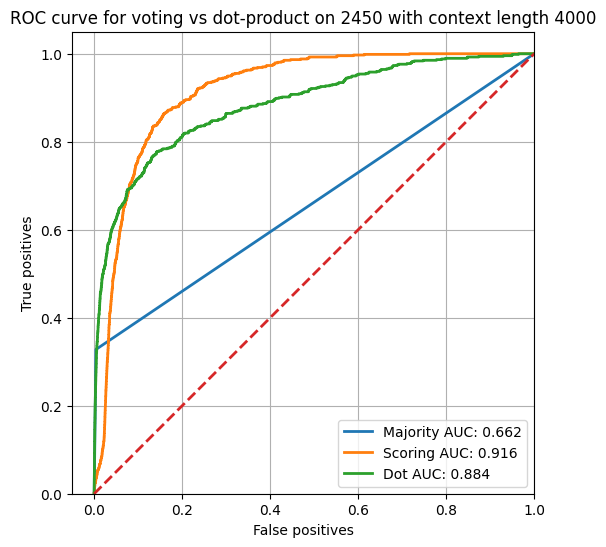

In [35]:
plt.figure(figsize=(10,6))
plot_roc("Majority", y_vote, y_preds_vote)
plot_roc("Scoring", y_score, y_preds_score)
plot_roc("Dot", y_test_all_ctx, y_dot_preds)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2)
plt.legend(loc='lower right')
plt.title(f'ROC curve for voting vs dot-product on {book} with context length {embedding_length}')
plt.show()